nodes.shape=(8, 8, 2)


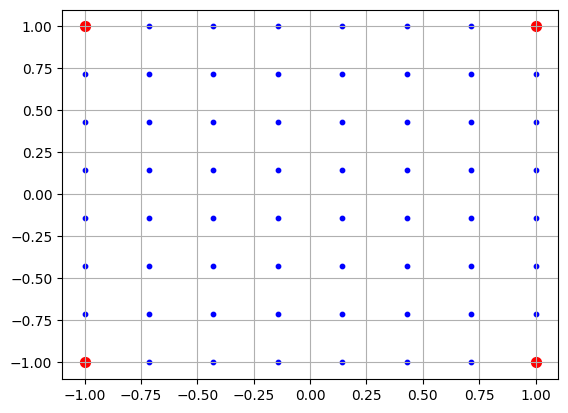

In [13]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = 4
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 8
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
# nodes = nodes.reshape((1,) + nodes.shape)
# nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

# Specify depots
## One depot node
# depot_indices = np.array([[0, 0]])
## Four depot nodes (one in each corner)
depot_indices = np.array([[0, 0], [n-1,n-1], [0, n-1], [n-1, 0]])
# print(f"{depot_indices=}")
target_indices = []
for i in range(n):
    for j in range(n):
        is_depot = False
        for depot in depot_indices:
            if i == depot[0] and j == depot[1]:
                is_depot = True
                continue
        if not is_depot:
            target_indices.append([i,j])
target_indices = np.array(target_indices)
# print(f"{target_indices=}")

# Chose starting depot node
# Make all robots start from same depot
# B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[:,:,0], nodes[:,:,1], c='blue', s=10)
plt.scatter(nodes[depot_indices[:,0],depot_indices[:,1],0], nodes[depot_indices[:,0],depot_indices[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [14]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = np.sqrt((nodes[i1,j1,0]-nodes[i2,j2,0]) ** 2 + (nodes[i1,j1,1]-nodes[i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
print(f"{cost.shape=}")


cost.shape=(8, 8, 8, 8)


In [15]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
x = m.addMVar((k,n,n,n,n), name='x', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    are_both_depot = False
    for d1 in depot_indices:
        if d1[0] != i1 or d1[1] != j1 : continue
        for d2 in depot_indices:
            if d2[0] != i2 or d2[1] != j2: continue
            are_both_depot = True
    if not are_both_depot:
        for ki in range(k):
            _ = m.addConstr(x[ki,i1,j1,i2,j2] <= 1)

In [16]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i1,j1,:,:].sum() == 1 for i1, j1 in target_indices)
_ = m.addConstrs(x[:,:,:,i1,j1].sum() == 1 for i1, j1 in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() <= 1)
    _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() <= 1)
    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,:,i1,j1]-x[ki,i1,j1,:,:]).sum() == 0 for i1 in range(n) for j1 in range(n))

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, j, i, j] == 0 for i in range(n) for j in range(n))

In [17]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,n,n,n,n), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i1, j1 in target_indices:
        for i2, j2 in itertools.product(range(n), range(n)):
            right_side += x[ki,i1,j1,i2,j2]
    _ = m.addConstr((p[ki,B_k[ki,0],B_k[ki,1],:,:] - p[ki,:,:,B_k[ki,0],B_k[ki,1]]).sum() == right_side)
    _ = m.addConstrs((p[ki,:,:,i1,j1] - p[ki,i1,j1,:,:]).sum() == x[ki,i1,j1,:,:].sum() for i1, j1 in target_indices)

    # (13) Make sure target capacity doesn't change when passing through a depot
    for i, (i1, j1) in enumerate(depot_indices):
        if i == ki: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for i2, j2 in itertools.product(range(n), range(n)):
            left_side += p[ki,i2,j2,i1,j1] - p[ki,i1,j1,i2,j2]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i1,j1,i2,j2] <= len(target_indices) * x[ki,i1,j1,i2,j2] for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))

In [18]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
L = np.sqrt(8) * 4 # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
r = m.addMVar((n,n), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    _ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[i2,j2] - r[i1,j1] + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in target_indices)

    # (17) and (18)
    _ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[i2,j2] - L + cost[i1,j1,i2,j2] <=  M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)

    # (19)
    _ = m.addConstrs(r[i1,j1] - cost[i1,j1,i2,j2] >= -M * (1 - x[ki,i1,j1,i2,j2]) for i1, j1 in target_indices for i2, j2 in depot_indices)

In [19]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [20]:
def visualize_paths_brute_force(edges):
    subplot_per_axis = int(np.ceil(np.sqrt(k)))
    fig, axs = plt.subplots(subplot_per_axis, subplot_per_axis)
    fig.suptitle(f"Paths for all robots (sum of costs={(cost * edges).sum():.3f})")
    fig.tight_layout()
    
    for ki in range(k):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        ax = axs[int(np.floor(ki/subplot_per_axis))][ki%subplot_per_axis]
        ax.set_title(f"Robot #{ki} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(nodes[:, :, 0], nodes[:, :, 1], c='blue', s=10)
        ax.scatter(nodes[depot_indices[:, 0], depot_indices[:, 1], 0], nodes[depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        ax.scatter(nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

        for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
            if edges[ki,i1, j1, i2, j2] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i1, j1, 0], nodes[i1, j1, 1], c="purple", s=8)
                ax.scatter(nodes[i2, j2, 0], nodes[i2, j2, 1], c="purple", s=8)
                ax.plot([nodes[i1, j1, 0], nodes[i2, j2, 0]], [nodes[i1, j1, 1], nodes[i2, j2, 1]], color="purple", linewidth=1)

        ax.grid()
    plt.show()

In [21]:
def get_next_nodes(edges, node):
    next_nodes = []
    for i1, j1 in itertools.product(range(n), range(n)):
        if edges[node[0],node[1],i1, j1]:
            next_nodes.append((i1,j1))
    return next_nodes

def visualize_paths_faster(edges):
    for ki in range(k):
        print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        fig = plt.figure()
        fig.suptitle(f"Path for Robot #{ki}")
        plt.scatter(nodes[:, :, 0], nodes[:, :, 1], c='blue', s=10)
        plt.scatter(nodes[depot_indices[:, 0], depot_indices[:, 1], 0], nodes[depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        plt.scatter(nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

        search_ongoing = True
        found = set()
        visited = set()
        # path_lookup = {}
        prev_node = (B_k[ki][0], B_k[ki][1])
        while search_ongoing:
            if (depot_indices == prev_node).all(1).any():
                print(f" -> D{prev_node}/({nodes[prev_node[0], prev_node[1], 0]:.2f},{nodes[prev_node[0], prev_node[1], 1]:.2f})")
            else:
                print(f" -> T{prev_node}/({nodes[prev_node[0], prev_node[1], 0]:.2f},{nodes[prev_node[0], prev_node[1], 1]:.2f})")

            neighbor_nodes = get_next_nodes(edges[ki], prev_node)
            print(f"\t{neighbor_nodes=}")

            for neighbor_node in neighbor_nodes:
                if not (depot_indices == neighbor_node).all(1).any() and neighbor_node not in found:
                    found.add(neighbor_node)

            found_next_node = False
            for neighbor_node in neighbor_nodes:
                if neighbor_node not in visited:
                    plt.scatter(nodes[prev_node[0], prev_node[1], 0], nodes[prev_node[0], prev_node[1], 1], c="purple", s=8)
                    plt.plot([nodes[prev_node[0], prev_node[1], 0], nodes[neighbor_node[0], neighbor_node[1], 0]], [nodes[prev_node[0], prev_node[1], 1], nodes[neighbor_node[0], neighbor_node[1], 1]], color="purple", linewidth=1)

                    if not (depot_indices == neighbor_node).all(1).any():
                        visited.add(neighbor_node)
                    prev_node = neighbor_node
                    found_next_node = True
                    break

            if found_next_node:
                search_ongoing = True
            elif not found_next_node and len(found) != len(visited):
                search_ongoing = True
                # print(f"{(found - visited)=}")
                print("Visualizing another loop...")
                prev_node = (found - visited).pop()
            else:
                search_ongoing = False

            # print(f"{found_next_node=} , {len(found)=} {len(visited)=}")

        plt.grid()
        plt.show()

In [22]:
class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    def __init__(self, model):
        self.model = model
        
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)

    def solve(self):
        self.model.optimize(MILPSolver.cb)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com
Optimize a model with 65284 rows, 32833 columns and 283140 nonzeros
Model fingerprint: 0x322393ed
Variable types: 65 continuous, 32768 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-01, 6e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 6e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 17316 rows and 512 columns
Presolve time: 0.19s
Presolved: 47968 rows, 32321 columns, 263716 nonzeros
Variable types: 61 continuous, 32260 integer (16108 binary)
Found a new solution with lower cost(81.901)!


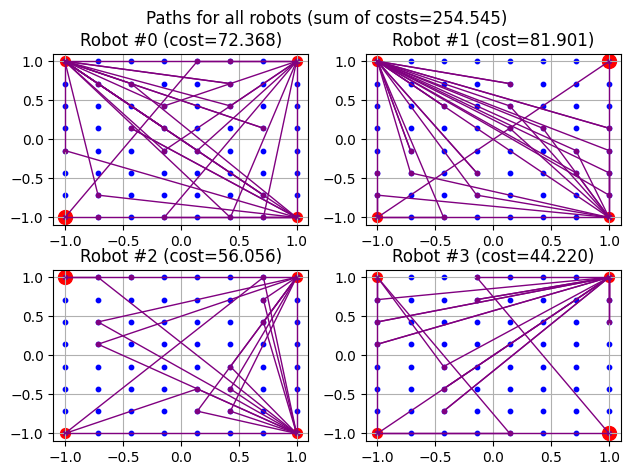

Found heuristic solution: objective 81.9012127
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   12341    1.0661763e+01   0.000000e+00   3.145148e+04      5s
Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 4.357143e+00, 25234 iterations, 6.87 seconds (33.72 work units)
Total elapsed time = 10.33s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.35714    0  237   81.90121    4.35714  94.7%     -   10s
Found a new solution with lower cost(9.501)!


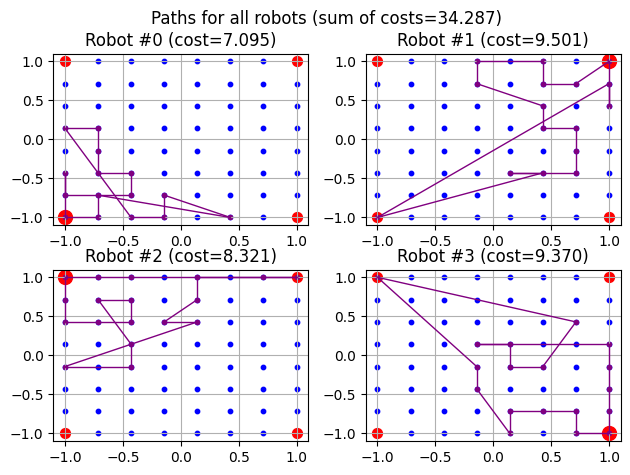

H    0     0                       9.5014259    4.35714  54.1%     -   11s
Found a new solution with lower cost(9.464)!


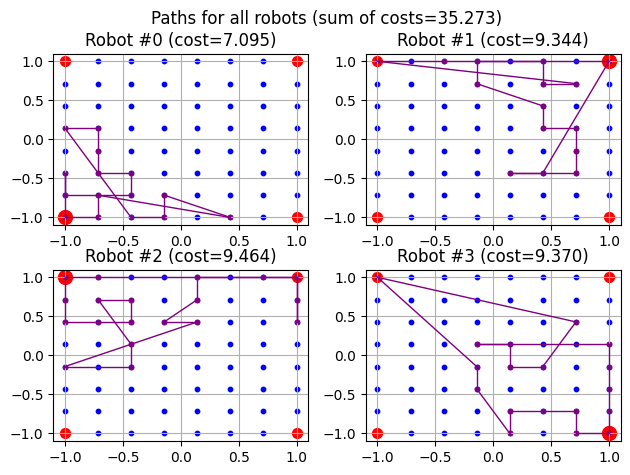

H    0     0                       9.4635479    4.35714  54.0%     -   11s
     0     0    4.35714    0  588    9.46355    4.35714  54.0%     -   17s
Found a new solution with lower cost(6.863)!


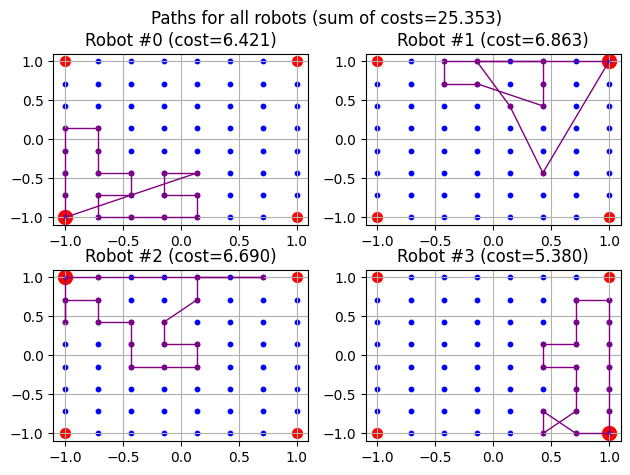

H    0     0                       6.8627367    4.35714  36.5%     -   33s
     0     0    4.35714    0  598    6.86274    4.35714  36.5%     -   35s
     0     0    4.35714    0  312    6.86274    4.35714  36.5%     -   52s
Found a new solution with lower cost(6.690)!


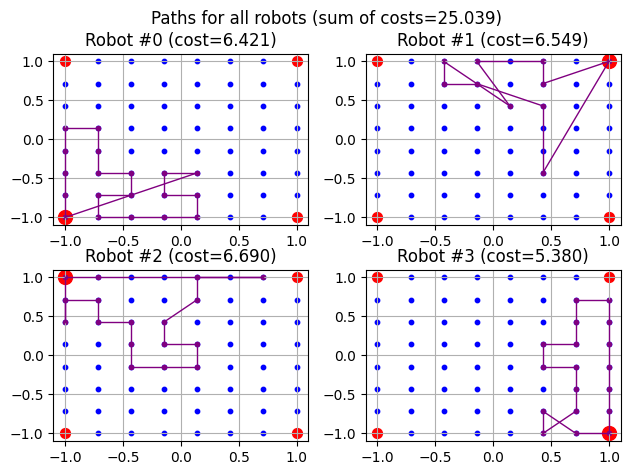

H    0     0                       6.6897753    4.35714  34.9%     -   53s
     0     0    4.35714    0  547    6.68978    4.35714  34.9%     -   57s
     0     0    4.35714    0  378    6.68978    4.35714  34.9%     -   80s
     0     0    4.35714    0  540    6.68978    4.35714  34.9%     -   85s
     0     0    4.35714    0  317    6.68978    4.35714  34.9%     -  108s
Found a new solution with lower cost(6.522)!


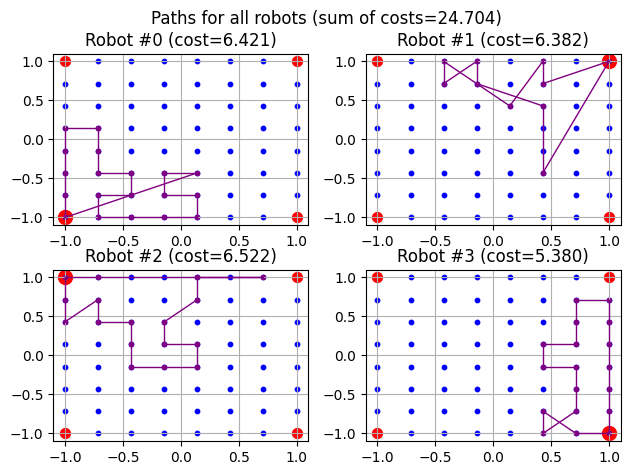

H    0     0                       6.5224077    4.35714  33.2%     -  114s
     0     0    4.35714    0  568    6.52241    4.35714  33.2%     -  119s
Found a new solution with lower cost(6.472)!


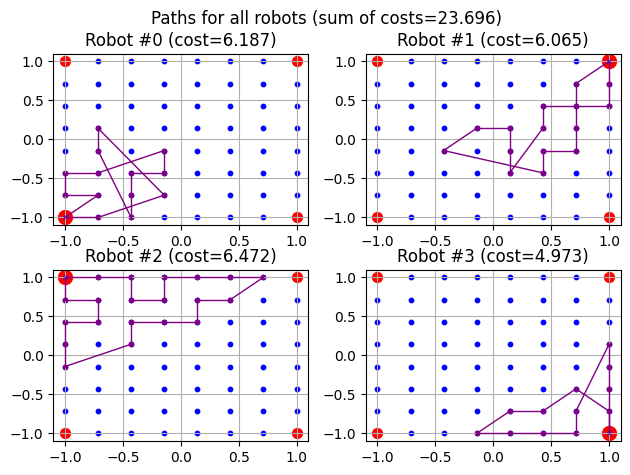

H    0     0                       6.4715090    4.35714  32.7%     -  143s
     0     0    4.35714    0  357    6.47151    4.35714  32.7%     -  147s
     0     0    4.35714    0  357    6.47151    4.35714  32.7%     -  151s
Found a new solution with lower cost(5.879)!


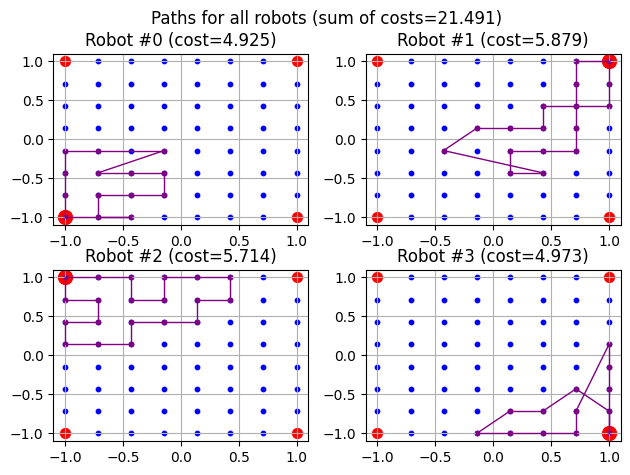

H    0     0                       5.8789975    4.35714  25.9%     -  196s
     0     2    4.35714    0  333    5.87900    4.35714  25.9%     -  203s
     1     4    4.35714    1  448    5.87900    4.35714  25.9% 21799  207s
     3     8    4.35714    2  534    5.87900    4.35714  25.9% 15580  215s
     7    15    4.35714    3  544    5.87900    4.35714  25.9% 15269  225s
    15    28    4.35714    4  614    5.87900    4.35714  25.9% 15264  249s
Found a new solution with lower cost(5.714)!


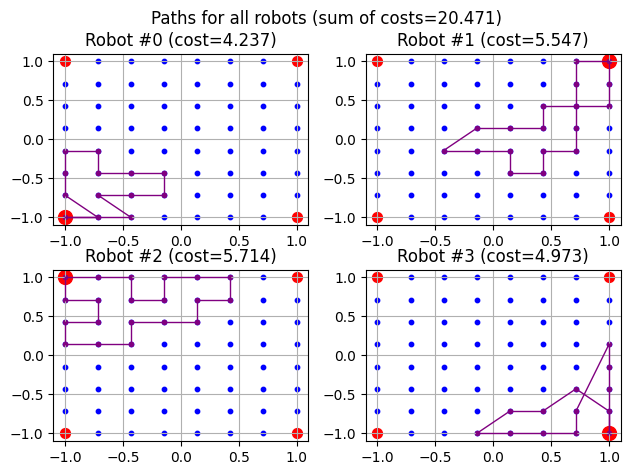

H   29    40                       5.7142857    4.35714  23.7% 18884  340s
Found a new solution with lower cost(5.143)!


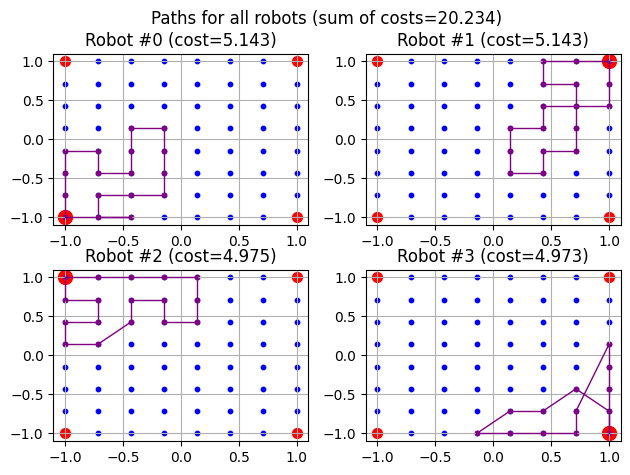

H   31    40                       5.1428571    4.35714  15.3% 18652  341s
Found a new solution with lower cost(4.975)!


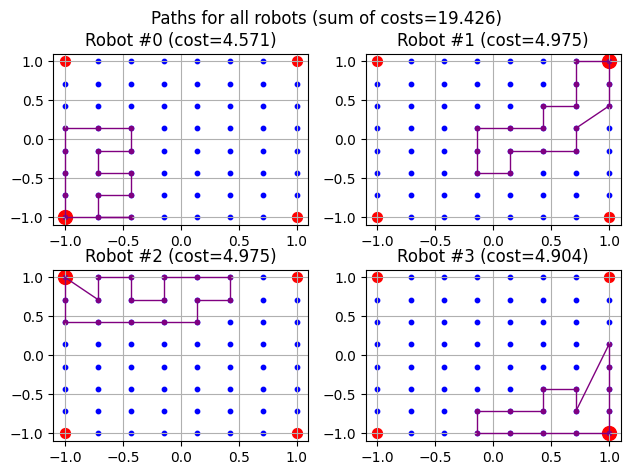

H   42    40                       4.9754896    4.35714  12.4% 18016  341s
    43    51    4.38673    6  608    4.97549    4.35714  12.4% 18301  373s
    57    65    4.36812    6  582    4.97549    4.35714  12.4% 16602  385s
    71    79    4.40108    7  613    4.97549    4.35714  12.4% 15046  411s
Found a new solution with lower cost(4.925)!


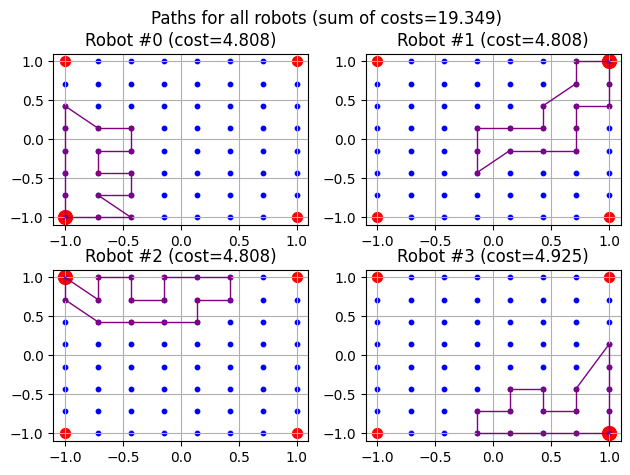

H   83    79                       4.9245909    4.35714  11.5% 14052  411s
    85    96    4.38951    7  576    4.92459    4.35714  11.5% 13996  423s
   102   112    4.41553    8  582    4.92459    4.35714  11.5% 13138  434s
   119   129    4.40137    8  557    4.92459    4.35714  11.5% 12328  470s
Found a new solution with lower cost(4.925)!


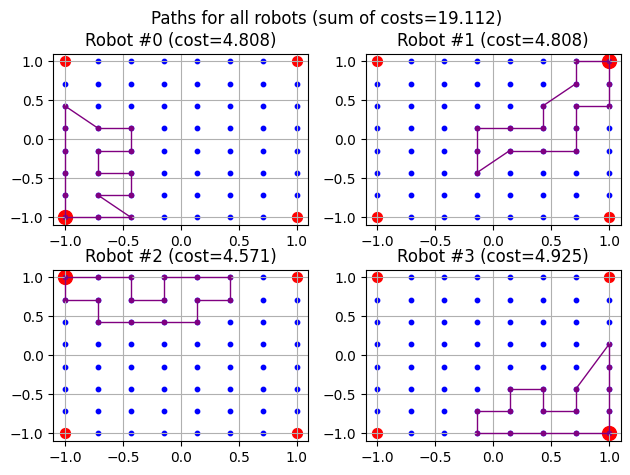

H  132   129                       4.9245908    4.35714  11.5% 12202  470s
   136   144    4.40137    9  574    4.92459    4.35714  11.5% 12047  481s
   154   165    4.43759    9  571    4.92459    4.35714  11.5% 11585  505s
   177   187    4.40137   10  554    4.92459    4.35714  11.5% 11321  533s
   199   212    4.45907   10  559    4.92459    4.35714  11.5% 11392  548s
   229   228    4.43320   11  620    4.92459    4.35714  11.5% 11141  610s
   248   251    4.46517   12  585    4.92459    4.35714  11.5% 10806  625s
   279   275    4.48805   13  588    4.92459    4.35714  11.5% 10183  640s
   313   308    4.46517   13  500    4.92459    4.35714  11.5%  9439  650s
   353   334    4.54028   14  492    4.92459    4.35714  11.5%  8790  666s
   396   352    4.57143   15  416    4.92459    4.35714  11.5%  8146  702s
Found a new solution with lower cost(4.808)!


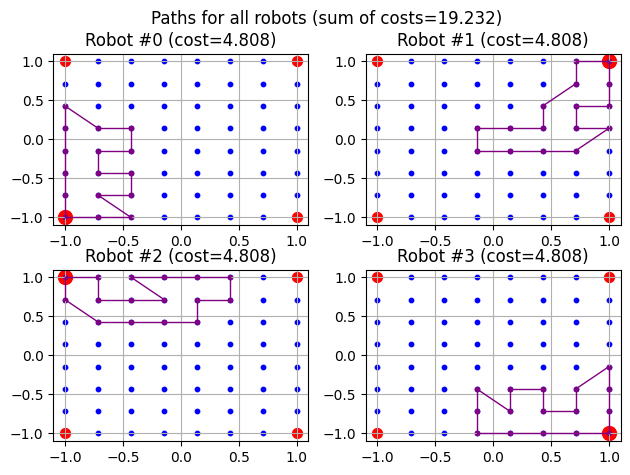

H  397   352                       4.8081220    4.35714  9.38%  8125  703s
   421   373    4.57143   17  467    4.80812    4.35714  9.38%  8101  715s
   474   409    4.57143   19  295    4.80812    4.35714  9.38%  7564  728s
   535   443    4.57143   21  298    4.80812    4.35714  9.38%  7044  742s
   593   487    4.57434   23  292    4.80812    4.35714  9.38%  6703  760s
   642   561    4.57143   24  293    4.80812    4.35714  9.38%  6338  768s
   736   622    4.57143   29  296    4.80812    4.35714  9.38%  5719  781s
   829   692    4.57143   31  324    4.80812    4.35714  9.38%  5279  793s
   934   747    4.57143   31  201    4.80812    4.35714  9.38%  4866  835s
  1032   774    4.57143   33  193    4.80812    4.35714  9.38%  4681  896s
  1098   789    4.57143   34  187    4.80812    4.35714  9.38%  4664  921s
  1141   853    4.57143   35  182    4.80812    4.35714  9.38%  4655  930s
  1242   868    4.57192   38  251    4.80812    4.35714  9.38%  4492  977s
Found a new solution with

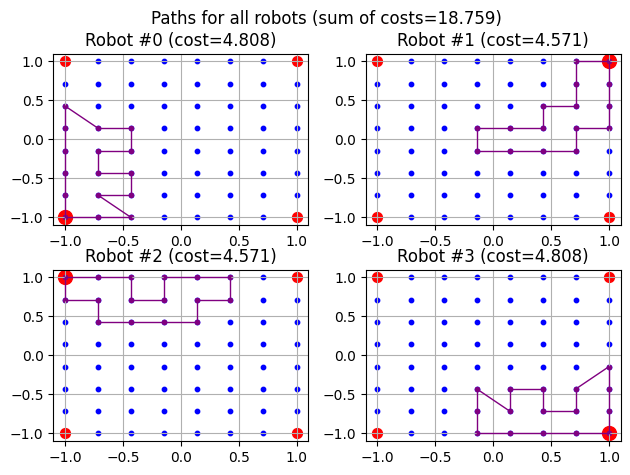

H 1253   868                       4.8081219    4.35714  9.38%  4468  978s
  1264   966    4.57192   39  246    4.80812    4.35714  9.38%  4453  992s
  1389  1057    4.57209   43  257    4.80812    4.35714  9.38%  4210 1038s
  1517  1165    4.57210   54  236    4.80812    4.35714  9.38%  4082 1058s
  1641  1189    4.57224   58  271    4.80812    4.35714  9.38%  3977 1087s
  1668  1324    4.57419   59  278    4.80812    4.35714  9.38%  3949 1109s
  1840  1474    4.57611   63  226    4.80812    4.35714  9.38%  3753 1126s
  2062  1475    4.74583   23  357    4.80812    4.35714  9.38%  3492 1297s
  2064  1476    4.66846   26  237    4.80812    4.43320  7.80%  3489 1347s
  2065  1477    4.60590   19  340    4.80812    4.55222  5.32%  3487 1407s
  2066  1478    4.61593   49  505    4.80812    4.55222  5.32%  3485 1415s
  2069  1481    4.57143   20  357    4.80812    4.55271  5.31%  3593 1441s
  2071  1482    4.58314   20  483    4.80812    4.55271  5.31%  3589 1464s
  2072  1483    4.61978  

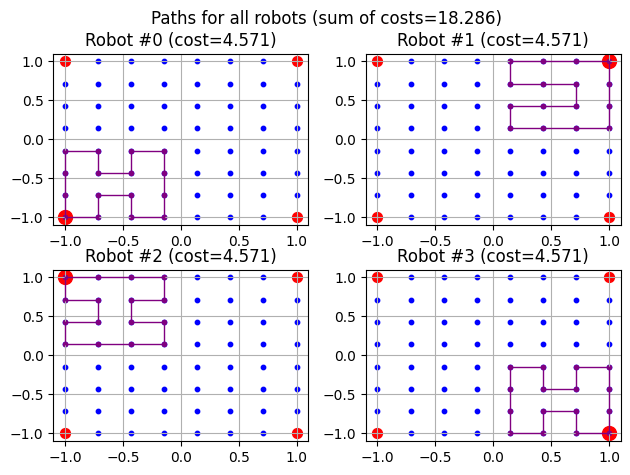

H 2111  1434                       4.5714286    4.57143  0.00%  3652 1629s

Cutting planes:
  Gomory: 2
  Cover: 1
  Implied bound: 5
  Projected implied bound: 8
  MIR: 13
  StrongCG: 4
  Flow cover: 68
  Zero half: 1
  RLT: 7
  Relax-and-lift: 7

Explored 2111 nodes (8202933 simplex iterations) in 1629.10 seconds (8636.39 work units)
Thread count was 14 (of 14 available processors)

Solution count 10: 4.57143 4.80812 4.80812 ... 6.47151

Optimal solution found (tolerance 1.00e-04)
Best objective 4.571428571429e+00, best bound 4.571428571429e+00, gap 0.0000%

User-callback calls 413112, time in user-callback 7.91 sec


In [23]:
m._x = x
solver = MILPSolver(m)
solver.solve()

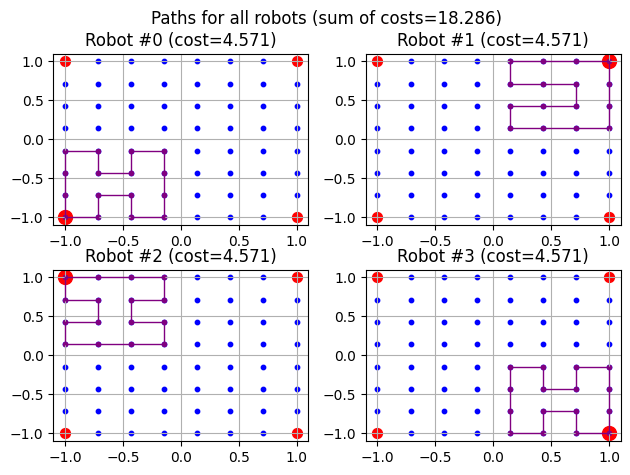

In [24]:
visualize_paths_brute_force(MILPSolver.min_cost_edges)
# visualize_paths_faster(MILPSolver.min_cost_edges)